In [1]:
from sklearn.linear_model import ElasticNet
import pandas as pd
import xgboost as xgb
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, precision_score, label_ranking_average_precision_score
from sklearn.model_selection import GridSearchCV
from sklearn import svm, preprocessing
from xgboost import XGBRegressor
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import PolynomialFeatures

In [51]:
# Reactome DB term to gene lists. Will be used to subset genes to see if any particular pathway is more informative than the rest
import pickle
with open('data/reactome_term_dicts.pickle', 'rb') as handle:
    reactome_dict = pickle.load(handle)
    
reactome_df = pd.DataFrame.from_dict(reactome_dict)
reactome_df.head()

In [84]:
reactome_df[reactome_df.term.str.contains('jak')]

,term,gene_list,n_genes


In [59]:
apop_genes = reactome_df.loc[reactome_df.term=='apoptosis homo sapiens r-hsa-109581']['gene_list'].values
apop_genes = list(apop_genes[0])
dna_genes = reactome_df.loc[reactome_df.term=='dna repair homo sapiens r-hsa-73894']['gene_list'].values[0]

In [80]:
dna_genes[0:5]

['ABL1', 'ACTB', 'ACTL6A', 'ACTR5', 'ACTR8']

In [3]:
merged = pd.read_hdf('merged_depmap.h5', 'df')

In [12]:
# ccle_rna2 = pd.read_csv('data/depmap_data/CCLE_expression.csv')
# ccle_rna2.rename({'Unnamed: 0': 'cell_line'}, axis=1, inplace=True)
# ccle_rna2.set_index('cell_line', inplace=True)

gene_names = [i.split(' (')[0] for i in ccle_rna2.columns.values]

In [5]:
drug_names = pd.read_csv('data/depmap_data/primary-screen-replicate-collapsed-treatment-info.csv')['column_name']

In [28]:
def run_model(df, model, drugname, gene_list, plot=False):
    subset_genes = list(sorted(set(gene_list).intersection(set(df.columns.values))))
    X = df[subset_genes].copy()
    y = df[drugname].values.reshape(-1, 1)
    X = preprocessing.StandardScaler(with_mean=False).fit_transform(X)
    y = preprocessing.StandardScaler(with_mean=False).fit_transform(y).ravel()
#     print(y)
#     return
#     poly = PolynomialFeatures(degree=2)
#     X = poly.fit_transform(X)
     
    X_train, X_test, y_train, y_test = train_test_split(
        X,
        y,
        test_size=0.33, 
        shuffle=False, 
        random_state=69,
    )
    
#     print(X_train.shape, y_train.shape)
    model.fit(X_train, y_train)
    preds = model.predict(X_test)
    error = mean_squared_error(y_test, preds)
#     print(np.max(model.coef_))
    if plot:
        sns.regplot(y_train, model.predict(X_train), label='training set')
        sns.regplot(y_test, preds, label='test set')
        plt.xlabel("Actual")
        plt.ylabel("Predicted")
        plt.legend()
        plt.suptitle(f"{drugname} : RMSE = {error}")
    return error

1.736782792392946

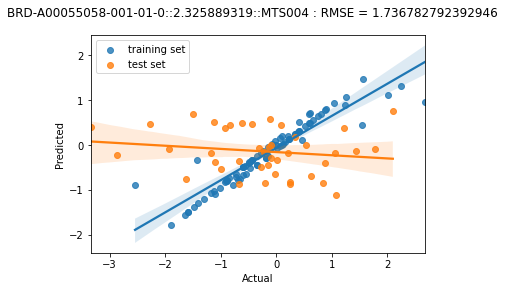

In [61]:
run_model(
    merged, 
    model=svm.SVR(gamma=0.001, C=10.),
    drugname=drug_names[0],
    gene_list=apop_genes,
    plot=True
    )

1.8725208391644197

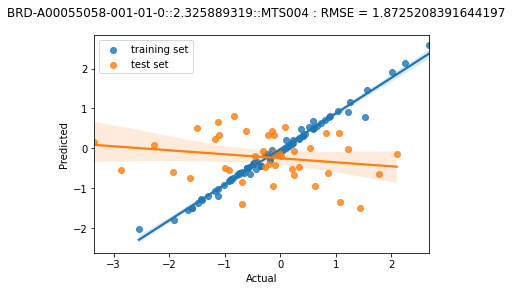

In [62]:
run_model(
    merged, 
    model=svm.SVR(gamma=0.001, C=10.),
    drugname=drug_names[0],
    gene_list=dna_genes,
    plot=True
    )


In [30]:
run_model(
    merged, 
    model=svm.SVR(gamma=0.001, C=10.),
    drugname=drug_names[0],
    gene_list=gene_names,
    plot=True
    )

1.3107931546967155

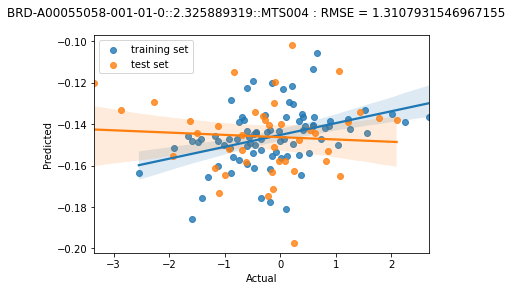

In [49]:
run_model(
    merged, 
    model=ElasticNet(
        random_state=0,
        normalize =False,
        max_iter=100000, 
        fit_intercept=False,
        l1_ratio=.5,
        alpha=0.5,
        selection ='random'
    ),
    drugname=drug_names[0],
    gene_list=apop_genes,
    plot=True
    )

1.3083206030614811

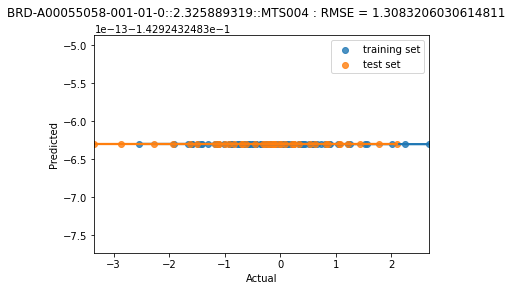

In [31]:
run_model(
    merged, 
    model=ElasticNet(random_state=0, normalize =False, max_iter=100000),
    drugname=drug_names[0],
    gene_list=gene_names,
    plot=True
    )

# Gradient boosted decision trees

XGBoost parameters


https://xgboost.readthedocs.io/en/latest/parameter.html

In [92]:
# fit model no training data
params = dict(
    # general params
    booster='gbtree',
    gpu_id=0,
    seed=100,
    # regularization
    reg_alpha=1, 
    reg_lambda=5,
    num_parallel_tree = 12, 
#     num_boost_round = 16,
    tree_method='gpu_hist',
    max_bin=256,
    objective='reg:squarederror',
    eval_metric='rmse',
    learning_rate=0.05,
    max_depth=5, 
    min_child_weight=1,
#     gamma=0,
    subsample=.5, # use half of data to resample
#     colsample_bytree=.8,
)

def create_importance_model(df, drugname, subset_list, save_name):
    subset_genes = list(sorted(set(subset_list).intersection(set(df.columns.values))))
#     X = df[subset_genes]
#     y = df[drugname]
#     X = preprocessing.StandardScaler().fit(X).transform(X)
    
    X = df[subset_genes].copy()
    y = df[drugname].values.reshape(-1, 1)
#     print(df[drugname].values)
    X = preprocessing.MinMaxScaler().fit_transform(X)
#     y = preprocessing.StandardScaler().fit_transform(y).ravel()
#     print(y)
    X_train, X_test, y_train, y_test = train_test_split(
        X,
        y,
        test_size=0.33, 
        shuffle=True, 
        random_state=69,
    )

    
    # organize data into xgb data matrix
    all_data = xgb.DMatrix(data=X, label=y)
    train = xgb.DMatrix(data=X_train, label=y_train)
    test = xgb.DMatrix(data=X_test, label=y_test)

    # add gene names as feature labels
    all_data.feature_names = subset_genes
    train.feature_names = subset_genes
    test.feature_names = subset_genes
    
    num_round = 100000
    results = dict()
    model = xgb.train(
        params, train, num_round,
        verbose_eval=False,
        early_stopping_rounds=100,
        evals=[(train, 'train'), (test, 'valid')],
        evals_result=results,
        
    )  
    
    feature_scores = model.get_fscore()
    s = pd.Series(list(feature_scores.values()), index=feature_scores)
    print(s.sort_values(ascending=False).head(5))
    # retrieve performance metrics
    epochs = len(results['train']['rmse'])
    x_axis = range(0, epochs)
    # plot log loss
    plt.figure(figsize=(12, 6))
    plt.subplot(121)
    plt.plot(x_axis, results['train']['rmse'], label='Train')
    plt.plot(x_axis, results['valid']['rmse'], label='Test')
    plt.legend()
    
    #trained 
    t_preds = model.predict(train, ntree_limit=model.best_ntree_limit)

    #predictions
    preds = model.predict(test)
    error = mean_squared_error(y_test, preds)
    error = "{0:.3f}".format(np.sqrt(error))
    print(f"MSE: {error}")

    # simple plot
    
    plt.subplot(122)
    sns.regplot(y_train, t_preds, label='training')
    sns.regplot(y_test, preds, label='prediction')
    plt.legend()
    plt.suptitle(f"{drugname} {save_name} : RMSE = {error}")

ACIN1    534
TFDP1    503
MAPT     407
ADD1     356
NMT1     309
dtype: int64
MSE: 0.396
ABL1     596
EYA2     472
PARP2    376
RHNO1    350
XRCC6    268
dtype: int64
MSE: 0.381


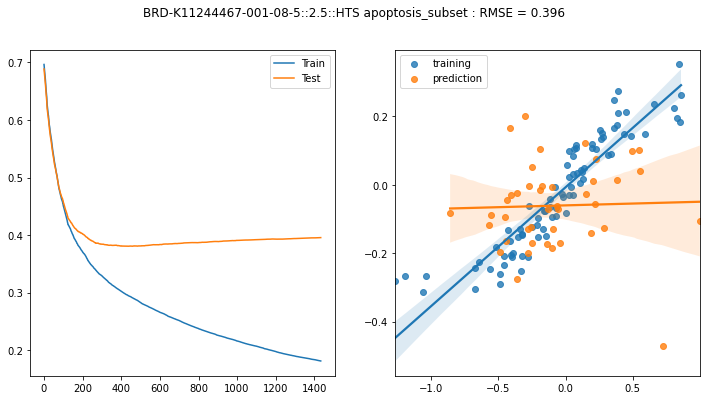

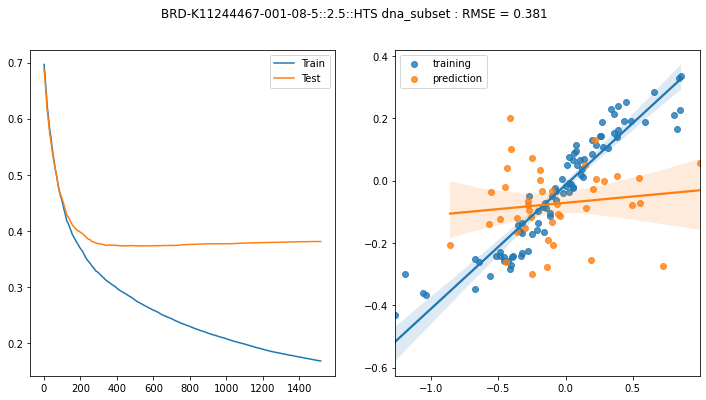

In [93]:
dn = 'BRD-K11244467-001-08-5::2.5::HTS'
create_importance_model(merged, dn, apop_genes, 'apoptosis_subset')
create_importance_model(merged, dn, dna_genes, 'dna_subset')